<a href="https://colab.research.google.com/github/ShiwangiMishra-Git/DeepLearningFinalProject/blob/main/ObjectDetection_without_Reinforcement_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Model Details:**


In this notebook we are showing how object detection models such as RCNN perform selective serach. Here we are not using any Reinforcement Learning agents. We are using the same dataset Pascal VOC2007 which were also used in the other notbook (Object Detection with Deep Reinforcement Learning.ipynb)

In [ ]:
!pip uninstall scipy

!pip install scipy==1.1.0

Uninstalling scipy-1.4.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/scipy-1.4.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/scipy/*
Proceed (y/n)? y
  Successfully uninstalled scipy-1.4.1
     |████████████████████████████████| 31.2MB 98kB/s 
ERROR: pymc3 3.11.2 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


The following codes randomly select 5 frames from PASCAL data and visualize its original image and segmented image.

In [ ]:
import os 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.misc
import skimage.segmentation
import skimage.feature
from copy import copy
from matplotlib.pyplot import imread


## This must be the location of the PASCAL VOC data. 
img_dir="/content/gdrive/MyDrive/DLProject/ HierarchicalObjectDetectionWithDeepRL/Pytorch_Deep_RL_1/datas/VOCdevkit/VOC2007/VOC2007/JPEGImages"

['006139.jpg' '008141.jpg' '005078.jpg' '009290.jpg' '003076.jpg']


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: DeprecationWarning:     `imread` is deprecated!
    `imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
    Use ``imageio.imread`` instead.


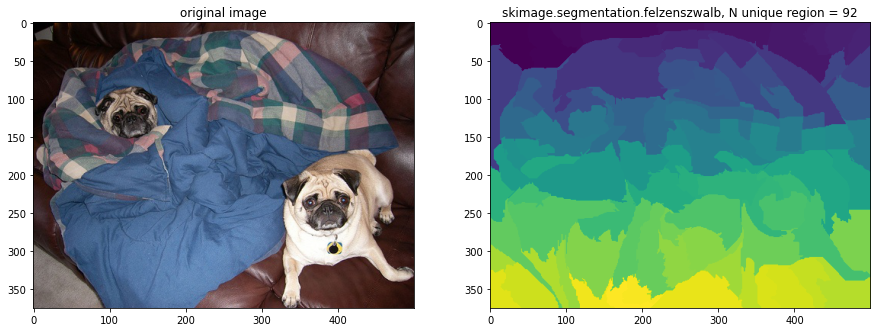

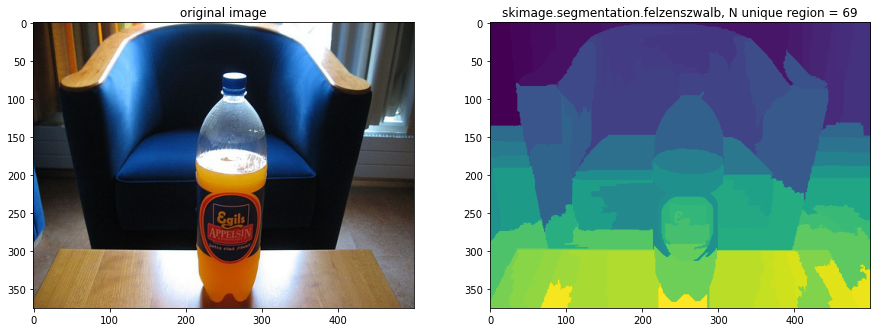

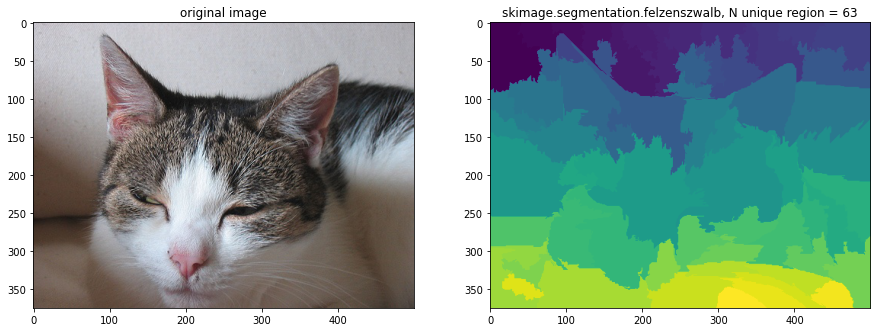

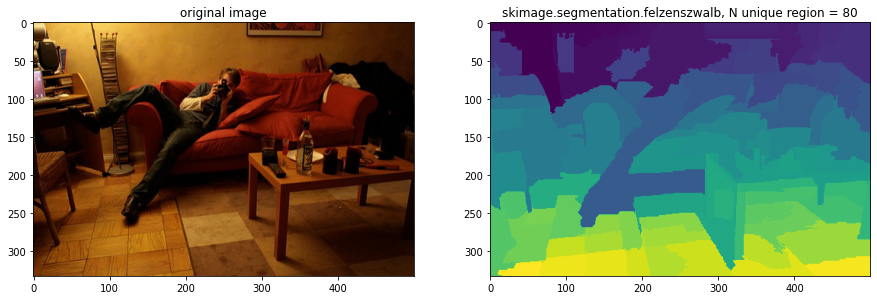

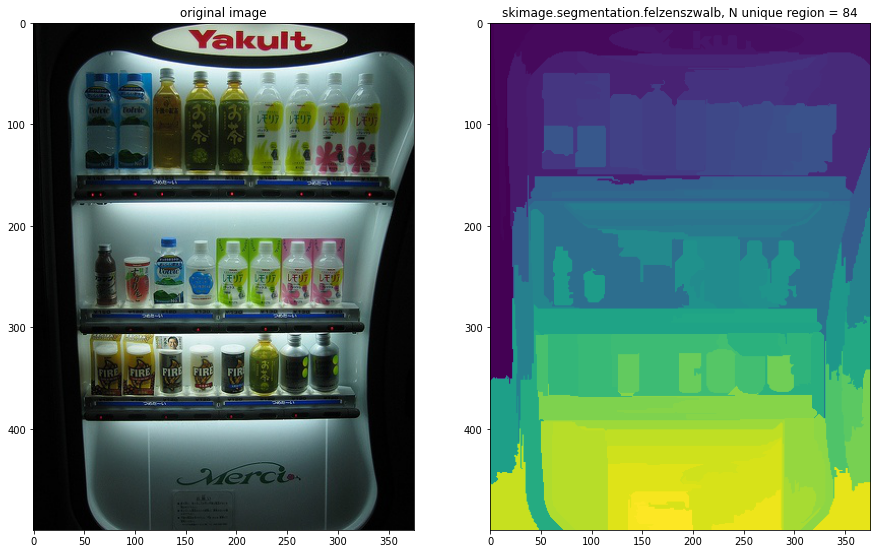

In [ ]:
def image_segmentation(img_8bit, scale = 1.0, sigma = 0.8, min_size = 50):
    '''
    J.R.R. Uijlings's hierarchical grouping algorithm 
    
    == input ==
    img_8bit : shape = (height, width, 3),
               8-bits degital image (each digit ranges between 0 - 255)
    
    == output ==
    img      : shape = (height, width, 4)
    '''
    # convert the image to range between 0 and 1
    img_float = skimage.util.img_as_float(img_8bit)
    im_mask   = skimage.segmentation.felzenszwalb(
                    img_float, 
                    scale    = scale, 
                    sigma    = sigma,
                    min_size = min_size)
    img       = np.dstack([img_8bit,im_mask])
    return(img)

scale    = 1.0
sigma    = 0.8
# min_size may be around 50 for better RCNN performance but for the sake of visualization, I will stick to min_size =500
min_size = 500 # 500 3000

np.random.seed(4)
listed_path = os.listdir(img_dir)
Nplot = 5
random_img_path = np.random.choice(listed_path,Nplot)
random_img_path.put(-1,'003076.jpg')
print(random_img_path)
for imgnm in random_img_path:
    # import 8 bits degital image (each digit ranges between 0 - 255)
    img_8bit  = scipy.misc.imread(os.path.join(img_dir,imgnm))
    img       = image_segmentation(img_8bit, scale, sigma, min_size)
    
    fig = plt.figure(figsize=(15,30))
    ax  = fig.add_subplot(1,2,1)
    ax.imshow(img_8bit)
    ax.set_title("original image")
    ax  = fig.add_subplot(1,2,2)
    ax.imshow(img[:,:,3])
    ax.set_title("skimage.segmentation.felzenszwalb, N unique region = {}".format(len(np.unique(img[:,:,3]))))
    plt.show()

In [ ]:
def extract_region(img):
    '''
    For each segmented region,
    extract smallest rectangle regions covering the smallest segmented region.
    
    == input ==
    img : (height, width, N channel)
          N channel = [R, G, B , L], L = label for the region
          only the L channel is used in this analysis 
    == output ==
    
    dictionary R :
    
    {0: {'labels': [0], 'max_x': 131, 'max_y': 74, 'min_x': 0,   'min_y': 0},
     1: {'labels': [1], 'max_x': 189, 'max_y': 37, 'min_x': 75,  'min_y': 0},
     2: {'labels': [2], 'max_x': 282, 'max_y': 38, 'min_x': 162, 'min_y': 0},
     3: {'labels': [3], 'max_x': 499, 'max_y': 23, 'min_x': 247, 'min_y': 0},
     4: {'labels': [4], 'max_x': 499, 'max_y': 74, 'min_x': 428, 'min_y': 13},
     5: {'labels': [5], 'max_x': 441, 'max_y': 76, 'min_x': 333, 'min_y': 16},
     6: {'labels': [6], 'max_x': 348, 'max_y': 80, 'min_x': 62,  'min_y': 21},
    '''
    ## only use the segmentation output
    img_segment = img[:,:,3]
    R = {}
    for y, i in enumerate(img_segment): ## along vertical axis 

        for x, l in enumerate(i): ## along horizontal axis
            # initialize a new region
            if l not in R:
                R[l] = {"min_x": np.Inf, 
                        "min_y": np.Inf,
                        "max_x": 0, 
                        "max_y": 0, 
                        "labels": [l]}

            # bounding box
            if R[l]["min_x"] > x:
                R[l]["min_x"] = x
            if R[l]["min_y"] > y:
                R[l]["min_y"] = y
            if R[l]["max_x"] < x:
                R[l]["max_x"] = x
            if R[l]["max_y"] < y:
                R[l]["max_y"] = y
    ## remove region if it does not have positive height or positive width
    
    Rcopy = copy(R)
    for key in R.keys():
        r = R[key]
        if (r["min_x"] == r["max_x"]) or (r["min_y"] == r["max_y"]):
            del Rcopy[key]
    return(Rcopy)
R = extract_region(img)
print("{} rectangle regions are found".format(len(R)))

84 rectangle regions are found


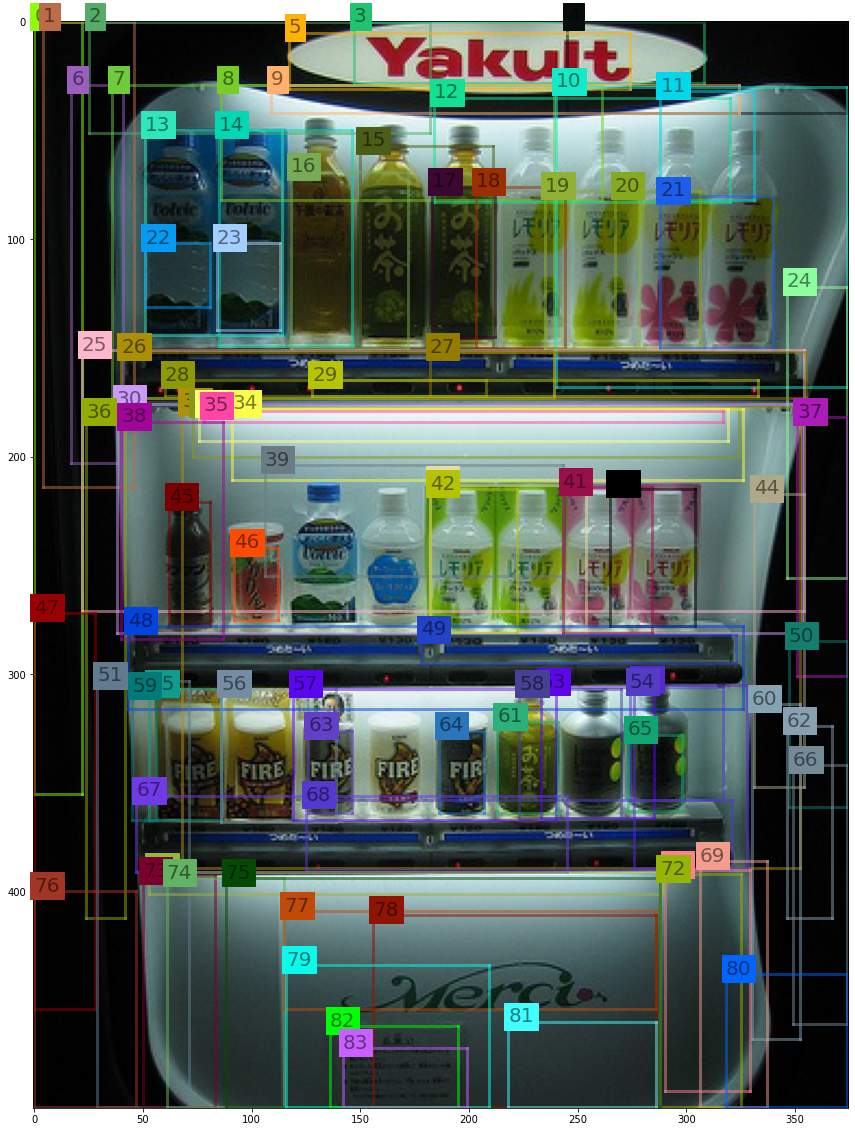

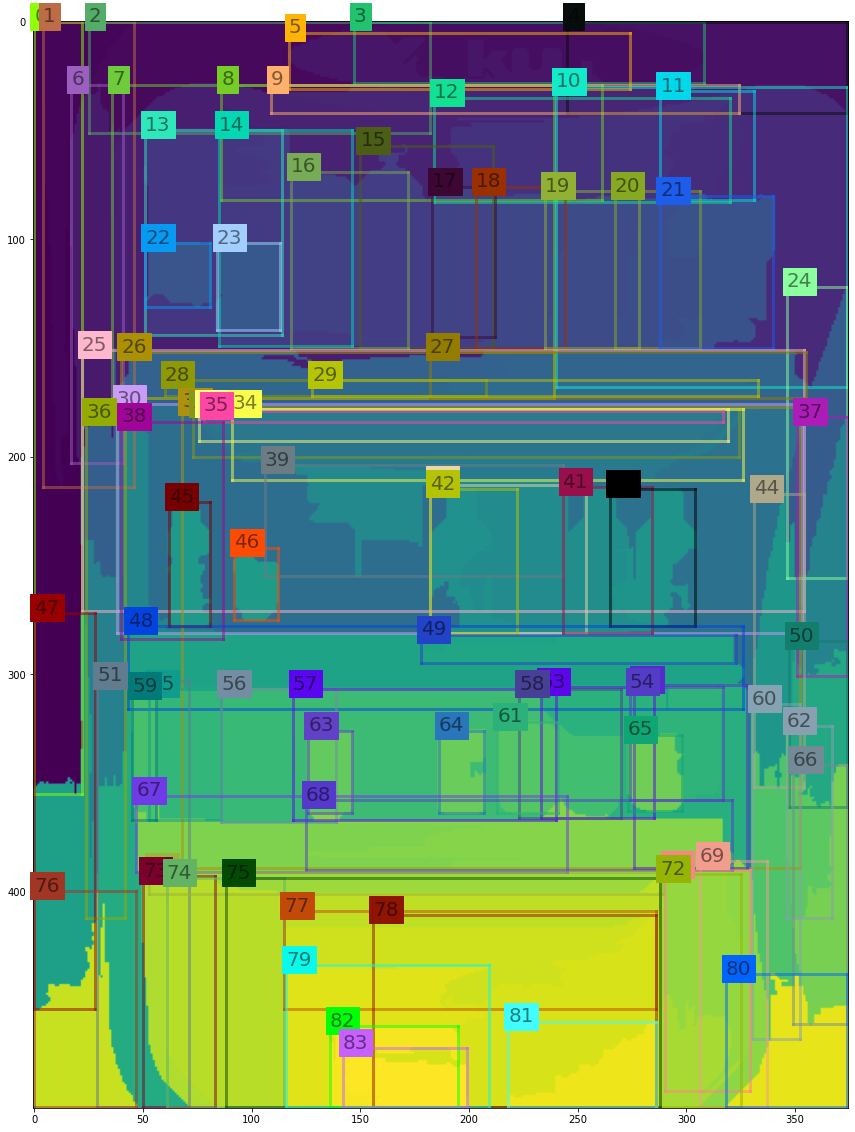

In [ ]:
def plt_rectangle(plt,label,x1,y1,x2,y2,color = "yellow", alpha=0.5):
    linewidth = 3
    if type(label) == list:
        linewidth = len(label)*3 + 2
        label = ""
        
    plt.text(x1,y1,label,fontsize=20,backgroundcolor=color,alpha=alpha)
    plt.plot([x1,x1],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x2,x2],[y1,y2], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y1,y1], linewidth=linewidth,color=color, alpha=alpha)
    plt.plot([x1,x2],[y2,y2], linewidth=linewidth,color=color, alpha=alpha)

figsize = (20,20)
plt.figure(figsize=figsize)    
plt.imshow(img[:,:,:3]/2**8)
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

plt.figure(figsize=figsize)    
plt.imshow(img[:,:,3])
for item, color in zip(R.values(),sns.xkcd_rgb.values()):
    x1 = item["min_x"]
    y1 = item["min_y"]
    x2 = item["max_x"]
    y2 = item["max_y"]
    label = item["labels"][0]
    plt_rectangle(plt,label,x1,y1,x2,y2,color=color)
plt.show()

### **Results:**



We can see in the there are 84 regions proposal (many propsals do not have bottle in it).
Hence, there is a need to improve region proposals step to reduce the computation cost with the help of Reinforment Learning. Please refer [Object_Detection_with_Deep_Reinforcement_Learning.ipynb](https://github.com/SM12345678/DeepLearningFinalProject/blob/main/Object_Detection_with_Deep_Reinforcement_Learning.ipynb) for further details.


References: https://fairyonice.github.io/Object_detection_with_PASCAL_VOC2012_selective_search.html